In [3]:
%matplotlib inline

from collections import defaultdict
from itertools import product, combinations_with_replacement, combinations

import rdkit
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
#from mobius import homolog_scanning

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors, rdMolDescriptors, Descriptors3D
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdmolops
from rdkit.Chem.MolStandardize import rdMolStandardize

from sklearn.decomposition import PCA
from sklearn.manifold import MDS, Isomap
from sklearn.preprocessing import StandardScaler

from scipy.spatial.distance import pdist, squareform

#from espsim import EmbedAlignConstrainedScore, EmbedAlignScore, ConstrainedEmbedMultipleConfs, GetEspSim, GetShapeSim

print(rdkit.__version__)

2023.03.1


In [4]:
def uncharge(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    
    return mol

In [5]:
def run_rxn(reactant, smarts): 
    ps = True
    while ps:
        rxn = AllChem.ReactionFromSmarts(smarts)
        ps = rxn.RunReactants((reactant,))
        if ps:
            reactant = ps[0][0] 
            Chem.SanitizeMol(reactant)

    return reactant

def protonator(m):
    rxns = ['[NX3;H2;!$(NC=[O,S]);!$(Na);!$(*[N,S,O,P]);!$(NC=[N;H0]);!$(NCC(F)F);!$(NCC#[C,N]);!$(NCC[ND2]);!$(NC=N):1]>>[NH3+:1]', #Primary aliphatic amines
          '[NX3;H1;!$(NC=[O,S]);!$(Na);!$(*[N,S,O,P]);!$(NC=[N;H0]);!$(NCC(F)F);!$(NCC#[C,N]);!$([N;R][C;R][O,S,P;R]);!$([N;R][C;R][C;R][O,S,P;R]);!$(NC[N+]);!$(NCC[N+]);!$(NC=N):1]>>[NH2+:1]', #Secondary aliphatic amines
          '[NX3;H0;!$(NC=[O,S]);!$(Na);!$(*[N,S,O,P]);!$(NC=[N;H0]);!$(NCC(F)F);!$(NCC#[C,N]);!$([N;R][C;R][O,S,P;R]);!$([N;R][C;R][C;R][O,S,P;R]);!$(NC[N+]);!$(NCC[N+]);!$(NC=N):1]>>[NH+:1]', #Tertiary aliphatic amines
          '[NX2;H0;!$(NC=[O,S]);!$(Na);!$(*=[N,S,O,P]);!$(*=[C;R][S;R]):1]>>[NH+:1]', #sp2 N
          '[NX2;H1;!$(NC=[O,S]);!$(Na);!$(*=[N,S,O,P]);!$(*=[C;R][S;R]):1]>>[NH2+:1]', #sp2 N
          #'[nX3;H1;$(*(n)n):1]>>[n-;H0:1]', #1,2,3-triazole
          '[nX3;H1;$(*(n)nn):1]>>[n-;H0:1]', #tetrazole
          '[O;H1;$(O[C,S]=O):1]>>[O-;H0:1]', #carboxylic and sulfinic acid
          '[O;H1;$(O[C,c;R]=[C,c;R][C,c]=O):1]>>[O-;H0:1]','[O;H1;$(Occc=O):1]>>[O-;H0:1]', #Phenol near C=O
          '[O;H1;$(Oaaa[nX3+]):1]>>[O-;H0:1]','[O;H1;$(Oaa[nX3+]):1]>>[O-;H0:1]','[O;H1;$(Oa[nX3+]):1]>>[O-;H0:1]','[O;H1;$(O[nX3+]):1]>>[O-;H0:1]', #Phenol near pyridinium
          '[O;H1;$(Ocnnn):1]>>[O-;H0:1]', '[O;H1;$(Onnn):1]>>[O-;H0:1]', #Phenol on 1,2,3-triazole
          '[O;H1;$(Oc(c[F,Cl,Br,I])c[F,Cl,Br,I]):1]>>[O-;H0:1]', #Phenol flanked by halides
          '[O;H1;$(OP(=[O,S])):1]>>[O-;H0:1]'] #Phosphate O

    for rxn in rxns:
        molb = run_rxn(m, rxn)
        if molb:
            m = molb

    return m

In [4]:
descriptors_list = [x[0] for x in Descriptors._descList]
print([x[0] for x in Descriptors._descList])

['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'Slo

In [5]:
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])

In [6]:
AA = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
data = []

are_donors = ['R', 'N', 'C', 'Q', 'H', 'K', 'M', 'S', 'T', 'Y', 'W']
are_acceptors = ['N', 'D', 'C', 'Q', 'E', 'H', 'M', 'S', 'T', 'Y']

for aa in AA:
    mol = Chem.MolFromFASTA(aa)
    mol = uncharge(mol)
    mol = protonator(mol)
    mol = Chem.AddHs(mol)
    
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)

    ds = list(calc.CalcDescriptors(mol))
    radius_gyration = Chem.Descriptors3D.RadiusOfGyration(mol)
    spherocity_index = Chem.Descriptors3D.SpherocityIndex(mol)
    asphericity = rdkit.Chem.Descriptors3D.Asphericity(mol)
    eccentricity = Chem.Descriptors3D.Eccentricity(mol)
    isf = Chem.Descriptors3D.InertialShapeFactor(mol)
    npr1 = Chem.Descriptors3D.NPR1(mol)
    npr2 = Chem.Descriptors3D.NPR2(mol)
    pmi1 = Chem.Descriptors3D.PMI1(mol)
    pmi2 = Chem.Descriptors3D.PMI2(mol)
    pmi3 = Chem.Descriptors3D.PMI3(mol)
    formal_charge = Chem.rdmolops.GetFormalCharge(mol)
    donor = 1 if aa in are_donors else 0
    acceptor = 1 if aa in are_acceptors else 0
    hn_backbone = 1 if aa != 'P' else 0
    o_backbone = 1
    
    data.append([aa] + ds + [radius_gyration, 
                             spherocity_index, asphericity, 
                             eccentricity, isf, npr1, npr2, pmi1, pmi2, pmi3,
                             formal_charge, donor, acceptor, hn_backbone, o_backbone])

columns = ['AA'] + descriptors_list + ['RadiusOfGyration', 
                                       'SpherocityIndex', 'Asphericity', 'Eccentricity', 
                                       'InertialShapeFactor', 'NPR1', 'NPR2', 'PMI1', 'PMI2', 'PMI3',
                                       'FormalCharge', 'donor', 'acceptor', 'hn_backbone', 'o_backbone']
descriptors = pd.DataFrame(data=data, columns=columns)
descriptors = descriptors.set_index(['AA'])

In [7]:
descriptors

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,NPR1,NPR2,PMI1,PMI2,PMI3,FormalCharge,donor,acceptor,hn_backbone,o_backbone
AA,,,,,,,,,,,,,,,,,,,,,
A,10.280347,-3.631944,10.280347,2.451389,0.381491,89.094,82.038,89.047678,36,0,...,0.519210,0.954980,103.446684,190.268937,199.238751,0,0,0,1,1
R,11.202894,-4.401030,11.202894,0.663690,0.188746,175.212,160.092,175.118952,70,0,...,0.170840,0.908518,300.855234,1599.932096,1761.035275,1,1,0,1,1
N,11.067153,-3.967824,11.067153,0.831458,0.410661,132.119,124.055,132.053492,52,0,...,0.470809,0.826153,225.431636,395.576621,478.817450,0,1,1,1,1
D,10.413681,-3.980324,10.413681,2.614861,0.416966,132.095,126.047,132.030231,52,0,...,0.265000,0.910694,163.648236,562.389411,617.539367,-1,0,1,1,1
C,10.462569,-3.514468,10.462569,0.411389,0.389598,121.161,114.105,121.019749,42,0,...,0.497757,0.896361,179.202475,322.707936,360.019951,0,1,1,1,1
Q,11.256083,-4.178403,11.256083,0.874954,0.431057,146.146,136.066,146.069142,58,0,...,0.368433,0.863757,259.541993,608.472195,704.448744,0,1,1,1,1
E,10.689606,-4.170069,10.689606,2.681644,0.434173,146.122,138.058,146.045881,58,0,...,0.216279,0.946072,201.328741,880.676149,930.876678,-1,0,1,1,1
G,9.805972,-3.319444,9.805972,2.243056,0.360155,75.067,70.027,75.032028,30,0,...,0.363442,0.810019,59.102973,131.725464,162.620190,0,0,0,1,1
H,10.987140,-3.801991,10.987140,0.064861,0.497170,155.157,146.085,155.069477,60,0,...,0.177905,0.941634,174.366601,922.906987,980.112574,0,1,1,1,1


In [8]:
descriptors.to_csv('AA_descriptors.csv')

In [258]:
descriptors_std = StandardScaler().fit_transform(descriptors)

## PCA

In [159]:
pca = PCA(n_components=7)
descriptors_2d = pca.fit_transform(descriptors_std)

descriptors_pca = pd.DataFrame(descriptors_2d) # Saving PCA values to a new table
descriptors_pca.index = descriptors.index
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]
print(descriptors_pca.head(5)) #Displays the PCA table)
print()
print(pca.explained_variance_ratio_) #Let's plot PC1 vs PC2 
print(sum(pca.explained_variance_ratio_))

         PC1        PC2        PC3       PC4       PC5       PC6       PC7
AA                                                                        
A  -8.421233  -2.872206  -1.615463  0.121941 -0.822242 -1.493951 -1.086529
R   6.757900  11.502140  -2.255287  6.579406 -0.501158  2.029720 -1.622440
N  -1.402117   2.127612   4.659087  1.691236 -2.068520  0.587629 -1.781324
D  -2.861008   0.195565  10.312572 -3.107389 -0.843203  0.800214  1.440061
C  -5.352880  -2.227440  -1.102219  4.390879  3.457936 -2.309252  4.886728

[0.29780445 0.13491576 0.11545728 0.08414506 0.07087322 0.069727
 0.05191538]
0.824838144695574


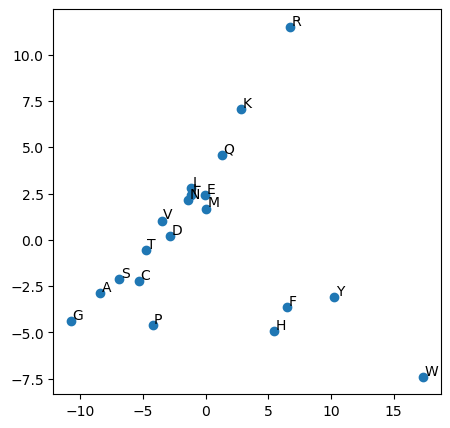

In [161]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(descriptors_pca['PC1'], descriptors_pca['PC2'])

for i, txt in enumerate(descriptors.index.values):
    ax.annotate(txt, (descriptors_pca['PC1'][i] + 0.1, descriptors_pca['PC2'][i] + 0.1))

plt.show()

In [162]:
dist = squareform(pdist(descriptors_pca.values))
dist = np.around(dist, 2)

In [163]:
mat = pd.DataFrame(data=dist, columns=AA, index=AA)
mat.to_csv('AA_similarity_matrix_pca.csv')
#mat

In [164]:
AAcomb = list(product(AA, repeat=2))
idx = np.argsort(mat.values.flatten())

for i in idx[::2]:
    print(AAcomb[i], mat.values.flatten()[i])

('A', 'A') 0.0
('C', 'C') 0.0
('E', 'E') 0.0
('H', 'H') 0.0
('N', 'N') 0.0
('M', 'M') 0.0
('P', 'P') 0.0
('T', 'T') 0.0
('Y', 'Y') 0.0
('R', 'R') 0.0
('L', 'I') 0.62
('V', 'I') 2.93
('V', 'L') 3.1
('G', 'A') 4.06
('D', 'E') 4.19
('N', 'Q') 4.62
('A', 'S') 5.14
('S', 'T') 5.28
('T', 'A') 5.38
('G', 'S') 5.41
('T', 'V') 7.25
('N', 'T') 7.8
('K', 'Q') 7.89
('C', 'M') 8.02
('L', 'K') 8.23
('T', 'G') 8.23
('A', 'V') 8.36
('E', 'Q') 8.39
('S', 'C') 8.42
('I', 'K') 8.51
('D', 'N') 8.53
('E', 'N') 8.92
('I', 'T') 9.06
('G', 'C') 9.07
('A', 'C') 9.11
('T', 'L') 9.27
('N', 'S') 9.45
('K', 'R') 9.88
('Q', 'D') 10.1
('K', 'M') 10.29
('K', 'V') 10.35
('Q', 'T') 10.57
('I', 'A') 10.93
('A', 'I') 10.93
('F', 'Y') 10.94
('C', 'T') 11.02
('N', 'A') 11.07
('I', 'F') 11.07
('K', 'N') 11.09
('A', 'L') 11.1
('Q', 'L') 11.14
('F', 'L') 11.15
('L', 'F') 11.15
('Q', 'I') 11.35
('V', 'Q') 11.58
('L', 'N') 11.61
('N', 'I') 11.67
('H', 'N') 11.85
('K', 'F') 11.88
('V', 'F') 11.95
('L', 'M') 11.99
('F', 'Q') 12.0

In [165]:
sm = SubstitutionMatrix('AA_similarity_matrix_pca.csv')

for aa in ['K', 'R', 'E', 'D', 'A', 'H']:
    print(aa, sm.substitutes(aa)[:10])

K ['Q' 'L' 'I' 'R' 'M' 'V' 'N' 'F' 'T' 'E']
R ['K' 'Q' 'N' 'M' 'L' 'I' 'H' 'F' 'T' 'V']
E ['D' 'Q' 'N' 'K' 'T' 'F' 'V' 'L' 'I' 'M']
D ['E' 'N' 'Q' 'T' 'S' 'A' 'V' 'G' 'L' 'C']
A ['G' 'S' 'T' 'V' 'C' 'I' 'N' 'L' 'Q' 'M']
H ['N' 'F' 'Q' 'T' 'W' 'S' 'C' 'K' 'A' 'M']


# Manually engineered feature and standardized

In [9]:
columns = ['MolWt', 'MolLogP', 'FormalCharge', 'donor', 'acceptor', 'hn_backbone', 'o_backbone']
descriptors_std = StandardScaler().fit_transform(descriptors[columns])
pd.DataFrame(data=descriptors_std, index=descriptors.index, columns=columns)

,MolWt,MolLogP,FormalCharge,donor,acceptor,hn_backbone,o_backbone
AA,,,,,,,
A,-1.585499,0.149548,0.000000,-1.105542,-1.0,0.229416,0.0
R,1.270506,-2.200013,2.236068,0.904534,-1.0,0.229416,0.0
N,-0.158624,-0.894225,0.000000,0.904534,1.0,0.229416,0.0
D,-0.159420,-1.564903,-2.236068,-1.105542,1.0,0.229416,0.0
C,-0.522034,0.067378,0.000000,0.904534,1.0,0.229416,0.0
Q,0.306565,-0.538458,0.000000,0.904534,1.0,0.229416,0.0
E,0.305769,-1.209136,-2.236068,-1.105542,1.0,0.229416,0.0
G,-2.050689,-0.204760,0.000000,-1.105542,-1.0,0.229416,0.0
H,0.605405,0.100210,0.000000,0.904534,1.0,0.229416,0.0


In [10]:
dist = squareform(pdist(descriptors_std))
dist = np.around(dist, 2)

In [11]:
mat = pd.DataFrame(data=dist, columns=AA, index=AA)
mat.to_csv('AA_similarity_matrix.csv')

69.52404093375706


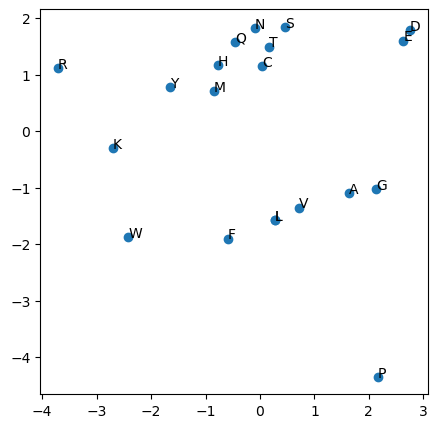

In [12]:
embedding = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto', max_iter=1000, n_init=10, eps=1e-10)
X_transformed = embedding.fit_transform(mat)

print(embedding.stress_)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X_transformed[:,0], X_transformed[:,1])

for i, txt in enumerate(AA):
    ax.annotate(txt, (X_transformed[i, 0], X_transformed[i, 1]))

plt.show()

In [264]:
sm = SubstitutionMatrix('AA_similarity_matrix.csv')

for aa in ['K', 'R', 'E', 'D', 'A', 'H', 'L', 'N', 'V', 'P']:
    print(aa, sm.substitutes(aa)[:10])

K ['R' 'Q' 'H' 'N' 'T' 'C' 'M' 'S' 'V' 'I']
R ['K' 'Q' 'N' 'H' 'T' 'S' 'C' 'M' 'Y' 'W']
E ['D' 'N' 'Q' 'T' 'H' 'S' 'C' 'M' 'V' 'A']
D ['E' 'N' 'Q' 'S' 'T' 'C' 'H' 'A' 'G' 'V']
A ['G' 'V' 'I' 'L' 'F' 'C' 'S' 'T' 'N' 'Q']
H ['Q' 'M' 'C' 'Y' 'N' 'T' 'S' 'W' 'K' 'F']
L ['I' 'V' 'F' 'A' 'G' 'M' 'C' 'H' 'W' 'T']
N ['Q' 'T' 'S' 'C' 'H' 'M' 'Y' 'E' 'D' 'K']
V ['L' 'I' 'A' 'G' 'F' 'C' 'M' 'T' 'H' 'S']
P ['V' 'A' 'I' 'L' 'G' 'F' 'C' 'T' 'S' 'N']


In [5]:
import os
import itertools
import copy

from mobius import homolog_scanning
from mobius import convert_FASTA_to_HELM
from mobius import utils

In [6]:
seq = convert_FASTA_to_HELM('AGHTY')[0]
print(seq)

new_seqs = []

for s in homolog_scanning(seq):
    print(s)
    new_seqs.append(s)
    
    if len(new_seqs) >= 96:
        break

PEPTIDE1{A.G.H.T.Y}$$$$V2.0
PEPTIDE1{G.G.H.T.Y}$$$$V2.0
PEPTIDE1{A.A.H.T.Y}$$$$V2.0
PEPTIDE1{A.G.Q.T.Y}$$$$V2.0
PEPTIDE1{A.G.H.C.Y}$$$$V2.0
PEPTIDE1{A.G.H.T.M}$$$$V2.0
PEPTIDE1{V.G.H.T.Y}$$$$V2.0
PEPTIDE1{A.V.H.T.Y}$$$$V2.0
PEPTIDE1{A.G.M.T.Y}$$$$V2.0
PEPTIDE1{A.G.H.S.Y}$$$$V2.0
PEPTIDE1{A.G.H.T.H}$$$$V2.0
PEPTIDE1{I.G.H.T.Y}$$$$V2.0
PEPTIDE1{A.I.H.T.Y}$$$$V2.0
PEPTIDE1{A.G.C.T.Y}$$$$V2.0
PEPTIDE1{A.G.H.N.Y}$$$$V2.0
PEPTIDE1{A.G.H.T.Q}$$$$V2.0
PEPTIDE1{L.G.H.T.Y}$$$$V2.0
PEPTIDE1{A.L.H.T.Y}$$$$V2.0
PEPTIDE1{A.G.Y.T.Y}$$$$V2.0
PEPTIDE1{A.G.H.Q.Y}$$$$V2.0
PEPTIDE1{A.G.H.T.C}$$$$V2.0
PEPTIDE1{F.G.H.T.Y}$$$$V2.0
PEPTIDE1{A.S.H.T.Y}$$$$V2.0
PEPTIDE1{A.G.N.T.Y}$$$$V2.0
PEPTIDE1{A.G.H.H.Y}$$$$V2.0
PEPTIDE1{A.G.H.T.W}$$$$V2.0
PEPTIDE1{C.G.H.T.Y}$$$$V2.0
PEPTIDE1{A.T.H.T.Y}$$$$V2.0
PEPTIDE1{A.G.T.T.Y}$$$$V2.0
PEPTIDE1{A.G.H.M.Y}$$$$V2.0
PEPTIDE1{A.G.H.T.N}$$$$V2.0
PEPTIDE1{S.G.H.T.Y}$$$$V2.0
PEPTIDE1{A.C.H.T.Y}$$$$V2.0
PEPTIDE1{A.G.S.T.Y}$$$$V2.0
PEPTIDE1{A.G.H.Y.Y}$$$$V2.0
PEPTIDE1{A.G.H.T.T}$

## ISOMAP

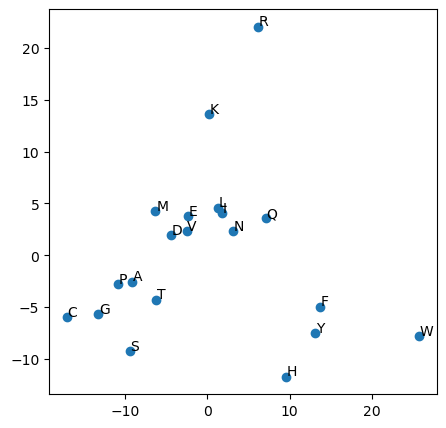

In [345]:
embedding = Isomap(n_components=2, n_neighbors=5)
X_transformed = embedding.fit_transform(descriptors_std)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X_transformed[:,0], X_transformed[:,1])

for i, txt in enumerate(df.index.values):
    ax.annotate(txt, (X_transformed[i, 0] + 0.1, X_transformed[i, 1] + 0.1))

plt.show()

In [346]:
dist = squareform(pdist(X_transformed))
dist = np.around(dist, 2)

mat = pd.DataFrame(data=dist, columns=AA, index=AA)
mat.to_csv('AA_similarity_matrix_isomap.csv')
#mat

In [347]:
sm = SubstitutionMatrix('AA_similarity_matrix_isomap.csv')

for aa in ['K', 'R', 'E', 'D', 'A', 'H']:
    print(aa, sm.substitutes(aa)[:10])

K ['L' 'I' 'E' 'R' 'M' 'N' 'V' 'Q' 'D' 'A']
R ['K' 'L' 'Q' 'I' 'N' 'E' 'V' 'M' 'D' 'F']
E ['V' 'D' 'L' 'M' 'I' 'N' 'T' 'A' 'Q' 'K']
D ['V' 'E' 'M' 'L' 'A' 'T' 'I' 'N' 'P' 'Q']
A ['P' 'T' 'G' 'D' 'S' 'M' 'V' 'C' 'E' 'L']
H ['Y' 'F' 'Q' 'N' 'W' 'T' 'I' 'L' 'V' 'S']


## MDS

3225.1472246021904


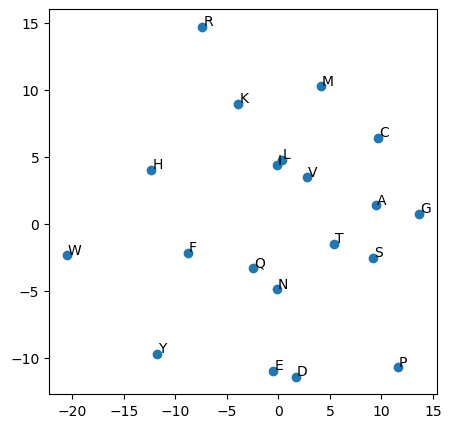

In [341]:
embedding = MDS(n_components=2, normalized_stress='auto', max_iter=1000, n_init=10, eps=1e-10)
X_transformed = embedding.fit_transform(descriptors_std)

print(embedding.stress_)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X_transformed[:,0], X_transformed[:,1])

for i, txt in enumerate(df.index.values):
    ax.annotate(txt, (X_transformed[i, 0] + 0.1, X_transformed[i, 1] + 0.1))

plt.show()

In [342]:
dist = np.around(embedding.dissimilarity_matrix_, 2)

mat = pd.DataFrame(data=dist, columns=AA, index=AA)
mat.to_csv('AA_similarity_matrix_mds.csv')
#mat

In [343]:
sm = SubstitutionMatrix('AA_similarity_matrix_mds.csv')

for aa in ['K', 'R', 'E', 'D', 'A', 'H']:
    print(aa, sm.substitutes(aa)[:10])

K ['L' 'I' 'V' 'Q' 'M' 'R' 'T' 'N' 'F' 'E']
R ['K' 'Q' 'N' 'L' 'I' 'M' 'V' 'T' 'F' 'E']
E ['D' 'Q' 'N' 'T' 'V' 'L' 'I' 'K' 'A' 'S']
D ['E' 'N' 'Q' 'T' 'A' 'S' 'V' 'L' 'G' 'C']
A ['G' 'S' 'V' 'T' 'C' 'I' 'L' 'N' 'M' 'Q']
H ['F' 'N' 'Q' 'T' 'S' 'I' 'L' 'V' 'M' 'A']


In [190]:
ed = pd.read_csv('e-descriptors.csv')
dist = squareform(pdist(ed[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].values))
dist = np.around(dist, 2)

mat = pd.DataFrame(data=dist, columns=AA, index=AA)
mat.to_csv('e-descriptors_similarity_matrix.csv')
mat

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
A,0.00,0.98,0.71,0.64,1.00,0.64,0.54,0.66,0.71,0.63,0.43,0.77,0.62,0.66,0.95,0.63,0.66,0.98,0.97,0.65
R,0.98,0.00,0.63,0.79,1.03,0.45,0.90,1.08,0.68,0.75,0.89,0.38,0.90,0.87,1.03,0.66,0.55,0.94,0.63,0.73
N,0.71,0.63,0.00,0.29,0.69,0.30,0.65,0.58,0.36,0.72,0.80,0.60,0.64,0.66,0.68,0.34,0.42,0.74,0.55,0.73
D,0.64,0.79,0.29,0.00,0.80,0.38,0.42,0.66,0.36,0.84,0.80,0.65,0.58,0.68,0.75,0.55,0.64,0.76,0.74,0.89
C,1.00,1.03,0.69,0.80,0.00,0.75,1.05,0.90,0.59,0.86,1.09,1.15,0.65,0.86,1.18,0.74,0.74,0.97,0.83,0.82
Q,0.64,0.45,0.30,0.38,0.75,0.00,0.53,0.78,0.30,0.61,0.68,0.41,0.53,0.61,0.85,0.45,0.41,0.74,0.57,0.63
E,0.54,0.90,0.65,0.42,1.05,0.53,0.00,0.92,0.54,0.89,0.72,0.65,0.58,0.74,0.99,0.81,0.84,0.88,0.97,0.96
G,0.66,1.08,0.58,0.66,0.90,0.78,0.92,0.00,0.82,0.81,0.83,0.97,0.90,0.81,0.63,0.45,0.60,1.02,0.87,0.81
H,0.71,0.68,0.36,0.36,0.59,0.30,0.54,0.82,0.00,0.67,0.76,0.67,0.35,0.53,0.88,0.60,0.59,0.60,0.58,0.74
I,0.63,0.75,0.72,0.84,0.86,0.61,0.89,0.81,0.67,0.00,0.38,0.74,0.60,0.41,0.90,0.60,0.47,0.73,0.58,0.24


In [344]:
sm = SubstitutionMatrix('e-descriptors_similarity_matrix.csv')

for aa in ['K', 'R', 'E', 'D', 'A', 'H']:
    print(aa, sm.substitutes(aa)[:10])

K ['R' 'Q' 'N' 'T' 'D' 'E' 'S' 'H' 'L' 'Y']
R ['K' 'Q' 'T' 'N' 'Y' 'S' 'H' 'V' 'I' 'D']
E ['D' 'Q' 'A' 'H' 'M' 'N' 'K' 'L' 'F' 'S']
D ['N' 'H' 'Q' 'E' 'S' 'M' 'T' 'A' 'K' 'G']
A ['L' 'E' 'M' 'S' 'I' 'D' 'Q' 'V' 'G' 'F']
H ['Q' 'M' 'N' 'D' 'F' 'E' 'Y' 'C' 'T' 'W']


In [202]:
from mobius import MorganFingerprint, Map4Fingerprint, MHFingerprint

In [203]:
mf = MHFingerprint(input_type='fasta')
fp = mf.transform(AA)

dist = squareform(pdist(fp, metric='jaccard'))
dist = np.around(dist, 2)

mat = pd.DataFrame(data=dist, columns=AA, index=AA)
#mat.to_csv('AA_similarity_matrix.csv')
mat

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
A,0.00,0.61,0.58,0.54,0.51,0.59,0.56,0.64,0.63,0.57,0.53,0.58,0.58,0.60,0.62,0.53,0.51,0.65,0.62,0.50
R,0.61,0.00,0.60,0.59,0.63,0.58,0.56,0.68,0.67,0.64,0.60,0.54,0.61,0.66,0.59,0.64,0.64,0.68,0.66,0.64
N,0.58,0.60,0.00,0.52,0.59,0.39,0.54,0.68,0.66,0.61,0.54,0.56,0.56,0.63,0.64,0.60,0.60,0.68,0.65,0.61
D,0.54,0.59,0.52,0.00,0.57,0.54,0.39,0.67,0.64,0.60,0.51,0.54,0.54,0.61,0.64,0.58,0.59,0.67,0.63,0.59
C,0.51,0.63,0.59,0.57,0.00,0.61,0.58,0.65,0.63,0.62,0.59,0.59,0.59,0.60,0.62,0.54,0.57,0.66,0.63,0.57
Q,0.59,0.58,0.39,0.54,0.61,0.00,0.51,0.69,0.66,0.62,0.57,0.54,0.58,0.64,0.63,0.61,0.62,0.68,0.66,0.62
E,0.56,0.56,0.54,0.39,0.58,0.51,0.00,0.68,0.64,0.61,0.53,0.49,0.54,0.61,0.63,0.58,0.59,0.66,0.64,0.59
G,0.64,0.68,0.68,0.67,0.65,0.69,0.68,0.00,0.71,0.70,0.68,0.65,0.69,0.68,0.67,0.64,0.67,0.71,0.68,0.67
H,0.63,0.67,0.66,0.64,0.63,0.66,0.64,0.71,0.00,0.65,0.67,0.66,0.66,0.61,0.68,0.64,0.65,0.64,0.64,0.65
I,0.57,0.64,0.61,0.60,0.62,0.62,0.61,0.70,0.65,0.00,0.54,0.61,0.62,0.64,0.65,0.61,0.61,0.67,0.65,0.45


## Espsim

In [35]:
AA = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']


mols = []

for aa in AA:
    mol = Chem.MolFromFASTA(aa)
    mol = uncharge(mol)
    mol = protonator(mol)
    mol = Chem.AddHs(mol)
    
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)
    
    mols.append(mol)

In [37]:
mcs = rdFMCS.FindMCS(mols, completeRingsOnly=True, atomCompare=rdFMCS.AtomCompare.CompareElements)
mcs.smartsString

'[#6](-&!@[#8])(-&!@[#6]-&!@[#1])=&!@[#8]'

In [38]:
def getMCSmol(mol, mcs):
    mcsp = Chem.MolFromSmarts(mcs.smartsString)
    match = mol.GetSubstructMatch(mcsp)
    match_smi = Chem.MolFragmentToSmiles(mol, atomsToUse=match, canonical=True)
    return Chem.MolFromSmiles(match_smi)

In [39]:
mcsmol = getMCSmol(mols[0], mcs)
AllChem.AddHs(mcsmol)
AllChem.EmbedMolecule(mcsmol, AllChem.ETKDGv2())
core = AllChem.DeleteSubstructs(AllChem.ReplaceSidechains(mols[0], mcsmol), Chem.MolFromSmiles('*'))

[12:50:59] Molecule does not have explicit Hs. Consider calling AddHs()


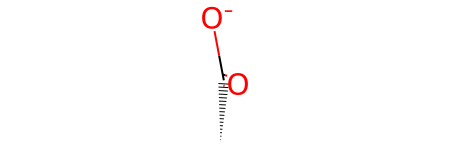

In [40]:
core

In [61]:
idx = range(20)
cmat = []

for pair in list(combinations(idx, 2)):    
    shapesim, espsim = EmbedAlignConstrainedScore(mols[pair[0]], [mols[pair[1]]], core, 
                                                  prbNumConfs=10, refNumConfs=10, 
                                                  partialCharges='ml', metric='tanimoto')
    score = (1. - shapesim[0]) + (1. - espsim[0])
    print('%s %s - %.3f %.3f - %.3f' % (AA[pair[0]], AA[pair[1]], shapesim[0], espsim[0], score))
    
    cmat.append(score)
    
dist = squareform(cmat)
dist = np.around(dist, 2)

A R - 0.515 0.530 - 0.955
A N - 0.706 0.759 - 0.536
A D - 0.530 0.126 - 1.344
A C - 0.808 0.990 - 0.202
A Q - 0.621 0.796 - 0.584
A E - 0.470 0.209 - 1.321
A G - 0.764 0.651 - 0.585
A H - 0.597 0.594 - 0.809
A I - 0.648 0.987 - 0.365
A L - 0.651 0.983 - 0.366
A K - 0.595 0.435 - 0.970
A M - 0.623 0.946 - 0.431
A F - 0.531 0.949 - 0.520
A P - 0.778 0.974 - 0.248
A S - 0.892 0.967 - 0.141
A T - 0.764 0.961 - 0.275
A W - 0.445 0.810 - 0.745
A Y - 0.499 0.845 - 0.656
A V - 0.737 0.992 - 0.271
R N - 0.648 0.547 - 0.805
R D - 0.524 0.092 - 1.384
R C - 0.613 0.503 - 0.884
R Q - 0.721 0.652 - 0.627
R E - 0.568 0.333 - 1.099
R G - 0.423 0.477 - 1.101
R H - 0.710 0.887 - 0.403
R I - 0.606 0.529 - 0.865
R L - 0.649 0.613 - 0.738
R K - 0.843 0.977 - 0.181
R M - 0.759 0.676 - 0.564
R F - 0.717 0.592 - 0.691
R P - 0.495 0.640 - 0.865
R S - 0.581 0.580 - 0.839
R T - 0.575 0.625 - 0.800
R W - 0.616 0.760 - 0.624
R Y - 0.769 0.708 - 0.523
R V - 0.558 0.545 - 0.897
N D - 0.654 0.124 - 1.223
N C - 0.848 

In [62]:
mat = pd.DataFrame(data=dist, columns=AA, index=AA)
mat.to_csv('AA_similarity_matrix_espsim.csv')
mat

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
A,0.00,0.96,0.54,1.34,0.20,0.58,1.32,0.59,0.81,0.36,0.37,0.97,0.43,0.52,0.25,0.14,0.27,0.74,0.66,0.27
R,0.96,0.00,0.81,1.38,0.88,0.63,1.10,1.10,0.40,0.87,0.74,0.18,0.56,0.69,0.87,0.84,0.80,0.62,0.52,0.90
N,0.54,0.81,0.00,1.22,0.41,0.60,1.23,0.73,0.50,0.45,0.27,0.97,0.40,0.48,0.44,0.48,0.45,0.70,0.54,0.42
D,1.34,1.38,1.22,0.00,0.68,1.00,1.43,1.04,0.91,0.62,1.21,1.22,0.68,0.75,1.26,0.72,0.62,0.92,0.87,1.13
C,0.20,0.88,0.41,0.68,0.00,0.49,1.13,0.62,0.65,0.24,0.23,0.76,0.30,0.39,0.27,0.10,0.16,0.60,0.49,0.18
Q,0.58,0.63,0.60,1.00,0.49,0.00,0.73,0.94,0.69,0.45,0.42,0.52,0.36,0.58,0.62,0.50,0.51,0.73,0.55,0.53
E,1.32,1.10,1.23,1.43,1.13,0.73,0.00,0.96,0.92,1.33,1.01,1.04,0.69,1.15,1.22,1.17,1.36,1.06,1.18,1.41
G,0.59,1.10,0.73,1.04,0.62,0.94,0.96,0.00,0.81,0.78,0.78,0.96,0.76,0.84,0.47,0.63,0.66,0.95,0.92,0.70
H,0.81,0.40,0.50,0.91,0.65,0.69,0.92,0.81,0.00,0.63,0.41,0.46,0.58,0.36,0.59,0.61,0.71,0.30,0.38,0.75
I,0.36,0.87,0.45,0.62,0.24,0.45,1.33,0.78,0.63,0.00,0.28,0.72,0.30,0.38,0.37,0.30,0.19,0.62,0.51,0.13


2.974544960730902


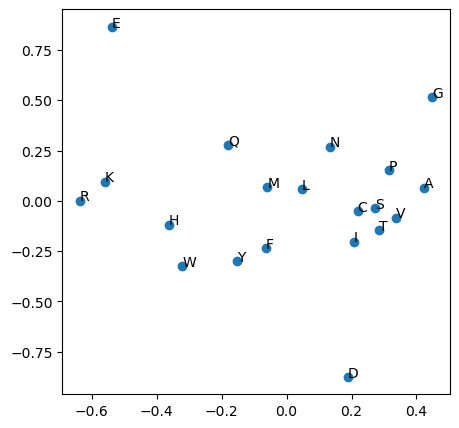

In [63]:
embedding = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto', max_iter=1000, n_init=10, eps=1e-10)
X_transformed = embedding.fit_transform(dist)

print(embedding.stress_)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X_transformed[:,0], X_transformed[:,1])

for i, txt in enumerate(AA):
    ax.annotate(txt, (X_transformed[i, 0], X_transformed[i, 1]))

plt.show()

In [64]:
sm = SubstitutionMatrix('AA_similarity_matrix_espsim.csv')

for aa in ['K', 'R', 'E', 'D', 'A', 'H']:
    print(aa, sm.substitutes(aa)[:10])

K ['R' 'M' 'H' 'Q' 'W' 'L' 'F' 'T' 'I' 'C']
R ['K' 'H' 'Y' 'M' 'W' 'Q' 'F' 'L' 'T' 'N']
E ['M' 'Q' 'H' 'G' 'L' 'K' 'W' 'R' 'C' 'F']
D ['I' 'T' 'C' 'M' 'S' 'F' 'Y' 'H' 'W' 'Q']
A ['S' 'C' 'P' 'T' 'V' 'I' 'L' 'M' 'F' 'N']
H ['W' 'F' 'Y' 'R' 'L' 'K' 'N' 'M' 'P' 'S']


In [128]:
idx = range(20)
shape = []
esp = []

for pair in list(combinations(idx, 2)):
    probe = mols[pair[0]]
    ref = mols[pair[1]]
    
    shapesim, espsim = EmbedAlignScore(probe, [ref], prbNumConfs=25, refNumConfs=25,
                                       partialCharges='mmff', metric='tanimoto', 
                                       getBestESP=True, integrate='gauss')
    print('%s %s - %.3f %.3f' % (AA[pair[0]], AA[pair[1]], shapesim[0], espsim[0]))
    
    shape.append(shapesim[0])
    esp.append(espsim[0])

mat_shape = squareform(shape)
mat_shape = np.around(shape, 2)

mat_esp = squareform(esp)
mat_esp = np.around(esp, 2)

A R - 0.516 0.133
A N - 0.710 0.921
A D - 0.712 0.091
A C - 0.813 0.972
A Q - 0.626 0.919
A E - 0.632 0.108
A G - 0.793 0.998
A H - 0.595 0.880
A I - 0.660 0.999
A L - 0.657 0.999
A K - 0.600 0.129
A M - 0.624 0.956
A F - 0.531 0.943
A P - 0.787 0.990
A S - 0.887 0.966
A T - 0.773 0.963
A W - 0.447 0.899
A Y - 0.502 0.929
A V - 0.747 0.999
R N - 0.647 0.151
R D - 0.643 0.000
R C - 0.606 0.145
R Q - 0.721 0.144
R E - 0.714 0.000
R G - 0.420 0.131
R H - 0.719 0.141
R I - 0.634 0.132
R L - 0.652 0.131
R K - 0.796 0.992
R M - 0.744 0.141
R F - 0.719 0.121
R P - 0.538 0.139
R S - 0.578 0.144
R T - 0.569 0.139
R W - 0.716 0.122
R Y - 0.773 0.127
R V - 0.566 0.130
N D - 0.970 0.104
N C - 0.839 0.938
N Q - 0.772 0.917
N E - 0.781 0.127
N G - 0.584 0.927
N H - 0.827 0.934
N I - 0.800 0.916
N L - 0.900 0.911
N K - 0.739 0.150
N M - 0.771 0.944
N F - 0.744 0.917
N P - 0.734 0.930
N S - 0.790 0.937
N T - 0.756 0.950
N W - 0.619 0.923
N Y - 0.702 0.935
N V - 0.743 0.918
D C - 0.850 0.103
D Q - 0.76

NameError: name 'mat_shape' is not defined

In [146]:
mat = ((1 - mat_shape) * 1.) + ((1 - mat_esp) * 2.)

mat = pd.DataFrame(data=dist, columns=AA, index=AA)
mat.to_csv('AA_similarity_matrix_espsim2.csv')
mat

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
A,0.00,1.23,0.30,1.13,0.17,0.36,1.17,0.16,0.42,0.26,0.26,1.17,0.33,0.41,0.17,0.12,0.21,0.52,0.44,0.19
R,1.23,0.00,1.11,1.27,1.15,1.06,1.21,1.30,1.07,1.14,1.13,0.16,1.05,1.09,1.21,1.17,1.18,1.09,1.04,1.20
N,0.30,1.11,0.00,0.92,0.18,0.25,1.04,0.39,0.20,0.23,0.16,1.05,0.23,0.27,0.27,0.22,0.23,0.36,0.29,0.28
D,1.13,1.27,0.92,0.00,1.01,1.07,0.18,1.22,1.01,1.07,1.00,1.20,1.08,1.10,1.09,1.05,1.07,1.17,1.13,1.09
C,0.17,1.15,0.18,1.01,0.00,0.27,1.08,0.28,0.31,0.21,0.20,1.08,0.25,0.31,0.17,0.08,0.11,0.42,0.35,0.15
Q,0.36,1.06,0.25,1.07,0.27,0.00,0.91,0.45,0.27,0.27,0.26,0.97,0.13,0.32,0.33,0.29,0.31,0.35,0.34,0.33
E,1.17,1.21,1.04,0.18,1.08,0.91,0.00,1.26,1.05,1.08,1.06,1.13,0.99,1.11,1.15,1.11,1.12,1.12,1.13,1.12
G,0.16,1.30,0.39,1.22,0.28,0.45,1.26,0.00,0.51,0.35,0.35,1.25,0.42,0.48,0.28,0.25,0.30,0.57,0.52,0.30
H,0.42,1.07,0.20,1.01,0.31,0.27,1.05,0.51,0.00,0.34,0.27,1.00,0.23,0.19,0.39,0.34,0.34,0.27,0.24,0.40
I,0.26,1.14,0.23,1.07,0.21,0.27,1.08,0.35,0.34,0.00,0.16,1.07,0.23,0.33,0.25,0.23,0.16,0.42,0.38,0.10


0.7710665435231507


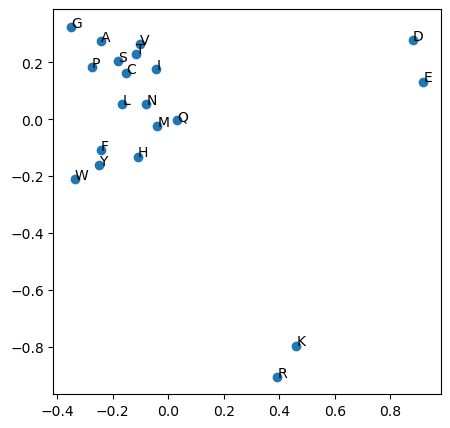

In [147]:
embedding = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto', max_iter=1000, n_init=10, eps=1e-10)
X_transformed = embedding.fit_transform(mat)

print(embedding.stress_)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X_transformed[:,0], X_transformed[:,1])

for i, txt in enumerate(AA):
    ax.annotate(txt, (X_transformed[i, 0], X_transformed[i, 1]))

plt.show()

In [148]:
sm = SubstitutionMatrix('AA_similarity_matrix_espsim2.csv')

for aa in ['K', 'R', 'E', 'D', 'A', 'H', 'W', 'L']:
    print(aa, sm.substitutes(aa)[:5])

K ['R' 'M' 'Q' 'H' 'F']
R ['K' 'Y' 'M' 'Q' 'H']
E ['D' 'Q' 'M' 'N' 'H']
D ['E' 'N' 'L' 'C' 'H']
A ['S' 'G' 'P' 'C' 'V']
H ['F' 'N' 'M' 'Y' 'W']
W ['F' 'Y' 'H' 'Q' 'N']
L ['I' 'N' 'C' 'M' 'F']


## Meiler embedding

In [18]:
df = pd.read_csv('meiler_embeddings.csv', index_col=0).T
df

,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7
ALA,1.28,0.05,1.00,0.31,6.11,0.42,0.23
ARG,2.34,0.29,6.13,-1.01,10.74,0.36,0.25
ASN,1.60,0.13,2.95,-0.60,6.52,0.21,0.22
ASP,1.60,0.11,2.78,-0.77,2.95,0.25,0.20
CYS,1.77,0.13,2.43,1.54,6.35,0.17,0.41
GLN,1.56,0.18,3.95,-0.22,5.65,0.35,0.25
GLU,1.56,0.15,3.78,-0.64,3.09,0.42,0.21
GLY,0.00,0.00,0.00,0.00,6.07,0.13,0.15
HIS,2.99,0.23,4.66,0.13,7.69,0.27,0.30
ILE,4.19,0.19,4.00,1.80,6.04,0.30,0.45


In [27]:
#descriptors_std = StandardScaler().fit_transform(df.values)
descriptors_std = df.values

In [28]:
dist = squareform(pdist(descriptors_std))
dist = np.around(dist, 2)

In [29]:
mat = pd.DataFrame(data=dist, columns=df.index.values, index=df.index.values)
mat.to_csv('meiler_similarity_matrix.csv')

42.59813450572722


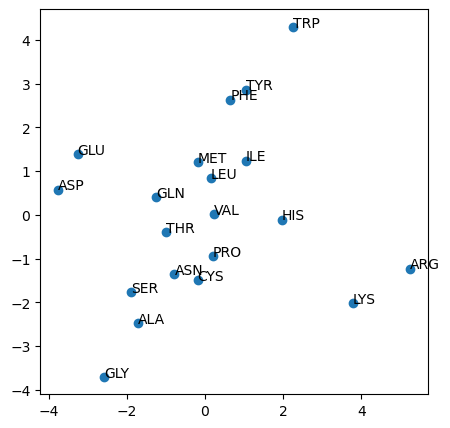

In [30]:
embedding = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto', max_iter=1000, n_init=10, eps=1e-10)
X_transformed = embedding.fit_transform(mat)

print(embedding.stress_)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X_transformed[:,0], X_transformed[:,1])

for i, txt in enumerate(df.index.values):
    ax.annotate(txt, (X_transformed[i, 0], X_transformed[i, 1]))

plt.show()